In [191]:
import sys
sys.path.insert(0, '..')

import torch
import os
import wandb
import random
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, StepLR, SequentialLR, LinearLR
from ignite.handlers.param_scheduler import create_lr_scheduler_with_warmup
from torch.utils.data import DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

from core.final.dataset import PSMDataset
from core.final.model import GalSpecNet, MetaModel, Informer

from core.multimodal.dataset2 import VPSMDatasetV2
from core.multimodal.model import ModelV1

from core.data.utils import preprocess_spectra, readLRSFits, preprocess_lc, get_vlc, add_noise, aug_metadata

# from core.metadata.model import MetaClassifier
# from models.Informer import Informer

In [17]:
df1 = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full/spectra_and_v_train.csv')
df2 = pd.read_csv('/home/mariia/AstroML/data/asassn/preprocessed_data/full/spectra_and_v_train_norm.csv')

In [18]:
df1['period']

0          0.369614
1          0.412779
2          0.450261
3         13.261893
4          0.334439
            ...    
17507      2.716803
17508    269.525193
17509     47.657608
17510      0.479847
17511      0.402175
Name: period, Length: 17512, dtype: float64

In [19]:
df2['period']

0       -1.185544
1       -1.144332
2       -1.111902
3        0.150315
4       -1.222859
           ...   
17507   -0.441252
17508    1.274082
17509    0.627597
17510   -1.088156
17511   -1.154042
Name: period, Length: 17512, dtype: float64

In [2]:
CLASSES = ['EW', 'SR', 'EA', 'RRAB', 'EB', 'ROT', 'RRC', 'HADS', 'M', 'DSCT']
METADATA_COLS = [
    'mean_vmag', 'amplitude', 'period', 'phot_g_mean_mag', 'e_phot_g_mean_mag', 'lksl_statistic',
    'rfr_score', 'phot_bp_mean_mag', 'e_phot_bp_mean_mag', 'phot_rp_mean_mag', 'e_phot_rp_mean_mag',
    'bp_rp', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
    'pmdec_error', 'j_mag', 'e_j_mag', 'h_mag', 'e_h_mag', 'k_mag', 'e_k_mag', 'w1_mag', 'e_w1_mag',
    'w2_mag', 'e_w2_mag', 'w3_mag', 'w4_mag', 'j_k', 'w1_w2', 'w3_w4', 'pm', 'ruwe'
]

In [192]:
def get_config(random_seed):
    config = {
        'project': 'AstroCLIP',     # 'AstroCLIP', 'AstroCLIPResults'
        'training_mode': 'clip',      # 'clip', 'classification'
        'model': 'ModelV1',  # 'ModelV0' or 'ModelV1'
        'random_seed': random_seed,
        'use_wandb': True,
        'save_weights': True,
        'weights_path': f'/home/mariia/AstroML/weights/{datetime.now().strftime("%Y-%m-%d-%H-%M")}',
        # 'use_pretrain': '/home/mariia/AstroML/weights/2024-07-25-14-18-es6hl0nb/weights-41.pth',
        'use_pretrain': None,
        'freeze': False,
        'fusion': 'avg',    # 'avg', 'concat'

        # Data General
        'dataset': 'VPSMDatasetV2',     # 'VPSMDataset' or 'VPSMDatasetV2'
        'data_root': '/home/mariia/AstroML/data/asassn/',
        'file': 'preprocessed_data/full/spectra_and_v',
        'classes': CLASSES,
        'min_samples': None,
        'max_samples': None,
        'noise': False,  # for train data only
        'noise_coef': 2,

        # Photometry
        'v_zip': 'asassnvarlc_vband_complete.zip',
        'v_prefix': 'vardb_files',
        'seq_len': 200,
        'phased': True,
        'clip': False,
        'aux': True,

        # Spectra
        'lamost_spec_dir': 'Spectra/v2',
        'spectra_v_file': 'spectra_v_merged.csv',
        'z_corr': False,

        # Photometry Model
        'p_encoder_layers': 8,
        'p_d_model': 128,
        'p_dropout': 0.2,
        'p_feature_size': 3,
        'p_n_heads': 4,
        'p_d_ff': 512,

        # Spectra Model
        's_hidden_dim': 512,
        's_dropout': 0.2,

        # Metadata Model
        'm_hidden_dim': 512,
        'm_dropout': 0.2,

        # MultiModal Model
        'hidden_dim': 1024,
        'ps_coef': 1,
        'mp_coef': 1,
        'sm_coef': 1,

        # Training
        'batch_size': 64,
        'lr': 1e-3,
        'weight_decay': 1e-3,
        'epochs': 100,
        'optimizer': 'AdamW',
        'early_stopping_patience': 10,

        # Learning Rate Scheduler
        'factor': 0.3,
        'patience': 5,
    }

    if config['aux']:
        config['p_feature_size'] += 4

    return config

In [193]:
config = get_config(42)

In [5]:
train1 = VPSMDatasetV2(
    split='train', data_root=config['data_root'], file=config['file'], v_zip=config['v_zip'],
    v_prefix=config['v_prefix'], lamost_spec_dir=config['lamost_spec_dir'], min_samples=config['min_samples'],
    max_samples=config['max_samples'], classes=config['classes'], seq_len=config['seq_len'],
    phased=config['phased'], clip=config['clip'], aux=config['aux'], z_corr=config['z_corr'],
    random_seed=config['random_seed'], noise=config['noise'], noise_coef=config['noise_coef'],
)
val1 = VPSMDatasetV2(
    split='val', data_root=config['data_root'], file=config['file'], v_zip=config['v_zip'],
    v_prefix=config['v_prefix'], lamost_spec_dir=config['lamost_spec_dir'], min_samples=config['min_samples'],
    max_samples=config['max_samples'], classes=config['classes'], seq_len=config['seq_len'],
    phased=config['phased'], clip=config['clip'], aux=config['aux'], z_corr=config['z_corr'],
    random_seed=config['random_seed'], noise=False,
)

In [194]:
config['meta_cols'] = METADATA_COLS
config['mode'] = 'all'

In [195]:
train2 = PSMDataset(config, split='train')
val2 = PSMDataset(config, split='val')

In [8]:
len(train1) == len(train2), len(val1) == len(val2)

(True, True)

In [9]:
idx = 100
photometry1, photometry_mask1, spectra1, metadata1, label1 = val1[idx]
photometry2, photometry_mask2, spectra2, metadata2, label2 = val2[idx]

In [10]:
np.array_equal(photometry1, photometry2)

True

In [11]:
np.array_equal(photometry_mask1, photometry_mask2)

True

In [12]:
np.array_equal(spectra1, spectra2)

True

In [13]:
np.array_equal(metadata1, metadata2)

True

In [14]:
np.array_equal(label1, label2)

True

In [190]:
photometry.shape

(200, 7)

In [38]:
metadata

array([-0.7062302 , -0.14822356, -1.1443323 , -0.3003968 , -0.08930137,
       -1.5725696 ,  1.5154452 , -0.7581926 , -0.22412843, -0.07214222,
       -0.04361604, -0.82607925,  0.29664075,  0.4472501 , -0.20569578,
        0.74528337,  0.3346219 ,  0.35099396,  0.25715104,  0.31477296,
       -0.13391519,  0.41439646, -0.13449664,  0.4472027 , -0.08887648,
        0.49404603, -0.43590912,  0.49463868, -0.36439356,  0.637051  ,
        0.6786752 , -0.9532438 , -0.15281057,  0.41622397, -0.37814832,
        2.2475352 ], dtype=float32)

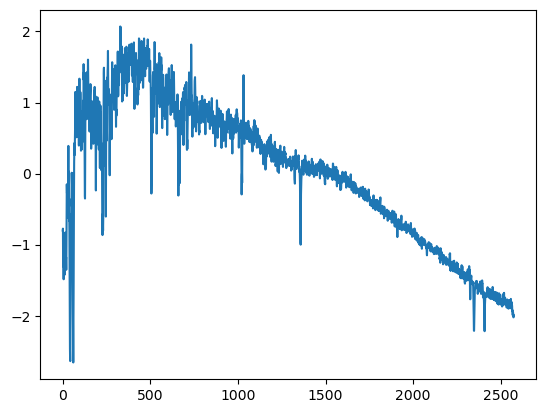

In [37]:
photometry, photometry_mask, spectra, metadata, label = train2[1]
plt.plot(spectra[0])

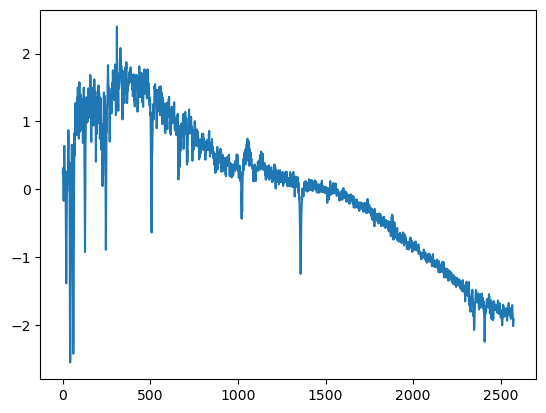

In [34]:
plt.plot(spectra[0])

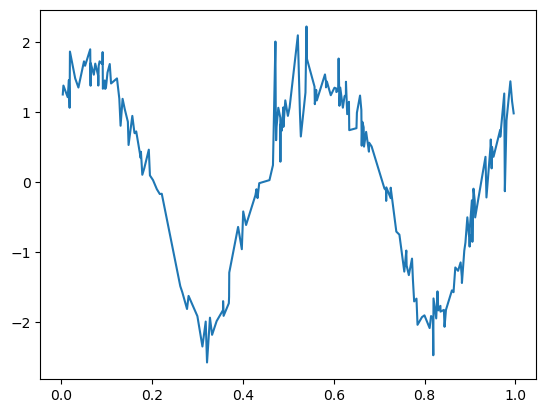

In [8]:
plt.plot(photometry[:, 0], photometry[:, 1])

In [10]:
i = 1
el = train2.df.iloc[i]
photometry = train2.get_vlc(el['name'])
spectra = train2.readLRSFits(os.path.join(train2.lamost_spec_dir, el['spec_filename']))
metadata = el[train2.meta_cols].values.astype(np.float32)

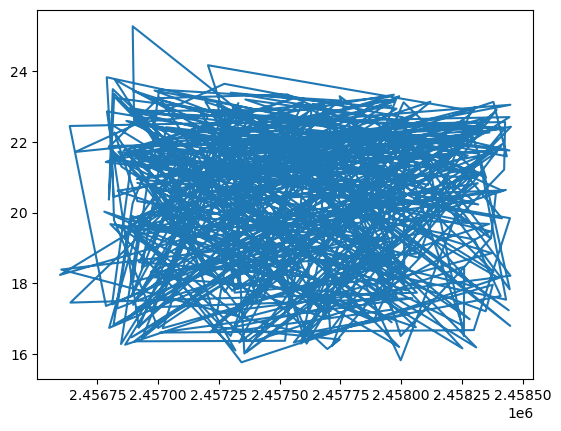

In [11]:
plt.plot(photometry[:, 0], photometry[:, 1])

In [12]:
sorted_indices = np.argsort(photometry[:, 0])
X = photometry[sorted_indices]

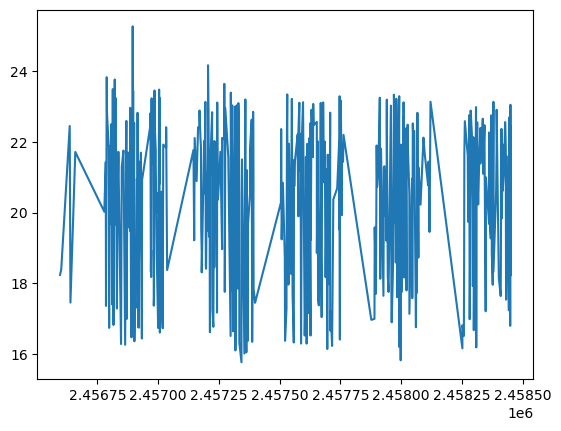

In [13]:
plt.plot(X[:, 0], X[:, 1])

In [14]:
# Normalize
mean = X[:, 1].mean()
std = stats.median_abs_deviation(X[:, 1])
# X[:, 0] = (X[:, 0] - X[:, 0].min()) / (X[:, 0].max() - X[:, 0].min())
X[:, 1] = (X[:, 1] - mean) / std
X[:, 2] = X[:, 2] / std

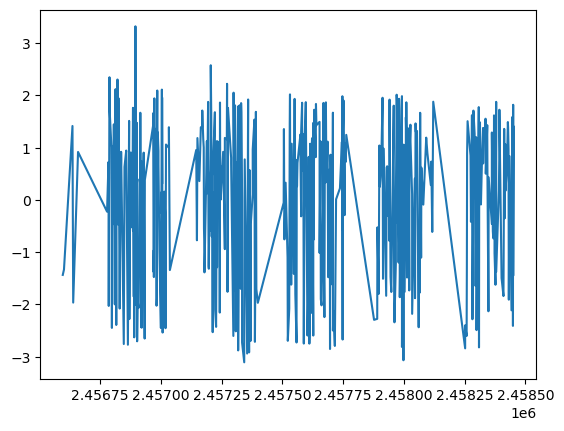

In [15]:
plt.plot(X[:, 0], X[:, 1])

In [17]:
# Trim if longer than seq_len
seq_len = 200

if X.shape[0] > seq_len:
    start = np.random.randint(0, len(X) - seq_len)
    X = X[start:start + seq_len, :]

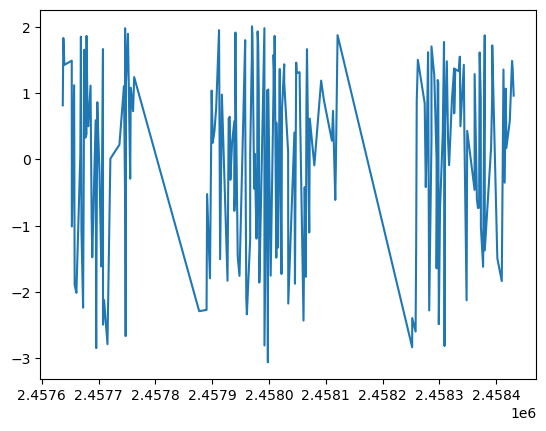

In [18]:
plt.plot(X[:, 0], X[:, 1])

In [21]:
real_period = 0.412779
X = np.vstack(((X[:, 0] % real_period) / real_period, X[:, 1], X[:, 2])).T

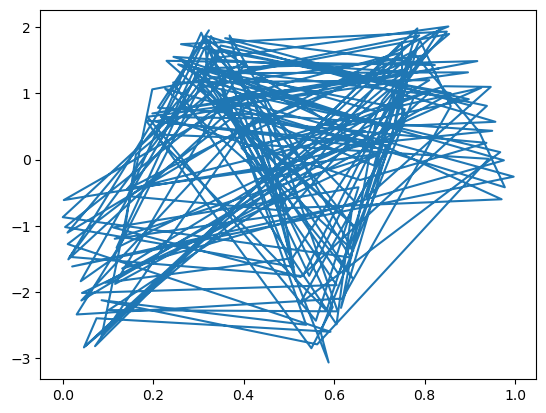

In [22]:
plt.plot(X[:, 0], X[:, 1])

In [23]:
sorted_indices = np.argsort(X[:, 0])
X = X[sorted_indices]

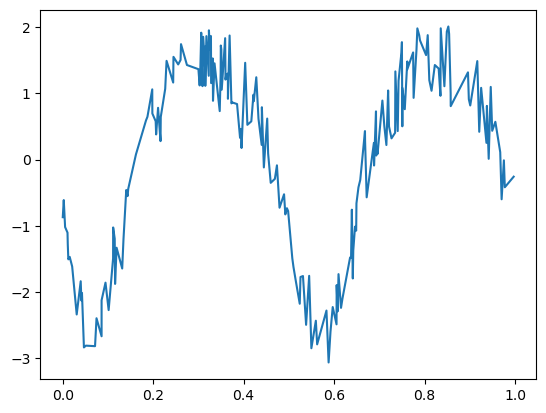

In [24]:
plt.plot(X[:, 0], X[:, 1])

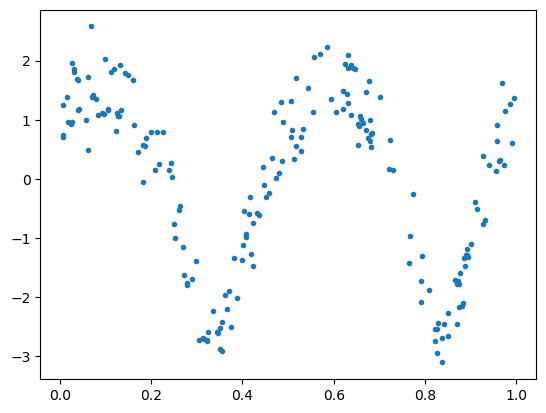

In [27]:
photometry, photometry_mask, spectra, metadata, label = train2[i]
plt.plot(photometry[:, 0], photometry[:, 1], '.')

In [12]:
X = photometry.copy()

sorted_indices = np.argsort(X[:, 0])
X = X[sorted_indices]

period = el['period']
X = np.vstack(((X[:, 0] % period) / period, X[:, 1], X[:, 2])).T

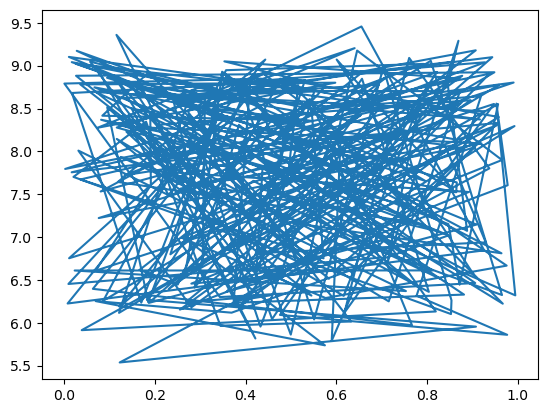

In [28]:
plt.plot(X[:, 0], X[:, 1])

In [24]:
period

-1.1855443545662308

In [25]:
real_period = 0.369614
X2 = np.vstack(((X[:, 0] % real_period) / real_period, X[:, 1], X[:, 2])).T

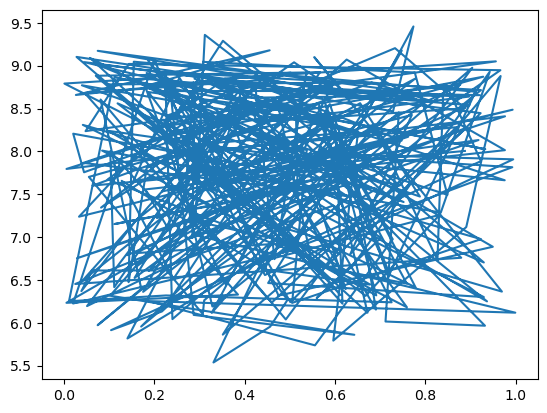

In [27]:
plt.plot(X2[:, 0], X2[:, 1])

In [15]:
old_model = ModelV1(config)

In [16]:
old_model.spectra_encoder

GalSpecNet(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (mp1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (mp2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (mp3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [196]:
config['num_classes'] = 10
config['s_use_classification'] = True
config['s_conv_channels'] = [1, 64, 64, 32, 32]
config['s_kernel_size'] = 3
config['s_mp_kernel_size'] = 4

In [197]:
s_model = GalSpecNet(config)

In [198]:
s_model

GalSpecNet(
  (layers): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 32, kernel_size=(3,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (10): ReLU()
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [206]:
config['batch_size'] = 512

In [207]:
train_dataloader = DataLoader(train2, batch_size=config['batch_size'], shuffle=False)

In [208]:
photometry, photometry_mask, spectra, metadata, label = next(iter(train_dataloader))

In [209]:
spectra.shape

torch.Size([512, 1, 2575])

In [210]:
for layer in s_model.layers:
    spectra = layer(spectra)
    print(layer, spectra.shape)

Conv1d(1, 64, kernel_size=(3,), stride=(1,)) torch.Size([512, 64, 2573])
ReLU() torch.Size([512, 64, 2573])
MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False) torch.Size([512, 64, 643])
Conv1d(64, 64, kernel_size=(3,), stride=(1,)) torch.Size([512, 64, 641])
ReLU() torch.Size([512, 64, 641])
MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False) torch.Size([512, 64, 160])
Conv1d(64, 32, kernel_size=(3,), stride=(1,)) torch.Size([512, 32, 158])
ReLU() torch.Size([512, 32, 158])
MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False) torch.Size([512, 32, 39])
Conv1d(32, 32, kernel_size=(3,), stride=(1,)) torch.Size([512, 32, 37])
ReLU() torch.Size([512, 32, 37])


In [211]:
spectra = spectra.view(spectra.shape[0], -1)
spectra.shape

torch.Size([512, 1184])

In [20]:
config['m_use_classification'] = True

In [21]:
m_model = MetaModel(config)

In [22]:
m_model

MetaModel(
  (model): Sequential(
    (0): Linear(in_features=36, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [23]:
old_model.metadata_encoder

MetaModel(
  (model): Sequential(
    (0): Linear(in_features=36, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [28]:
config['p_enc_in'] = 7    # feature size
config['p_d_model'] = 128
config['p_dropout'] = 0.2
config['p_factor'] = 1
config['p_output_attention'] = False
config['p_n_heads'] = 4
config['p_d_ff'] = 512
config['p_activation'] = 'gelu'
config['p_e_layers'] = 8

In [6]:
p_model = Informer(config)

KeyError: 'mode'

In [33]:
str(p_model) == str(old_model.photometry_encoder)

True

In [171]:
lr_lambda = lambda epoch: epoch / base_lr * (base_lr - warmup_lr) / warmup_epochs

In [176]:
base_lr = 1e-3
warmup_lr = 1e-5
warmup_epochs = 5

optimizer = Adam(s_model.parameters(), lr=base_lr)
scheduler1 = LambdaLR(optimizer, lr_lambda=lr_lambda)
scheduler2 = ExponentialLR(optimizer, gamma=0.9)
scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])

In [177]:
lrs = []

for i in range(30):
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])

/global/home/users/mariia/miniforge3/envs/astro/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [178]:
lrs[:8]

[0.00019800000000000002,
 0.00039600000000000003,
 0.0005940000000000001,
 0.0007920000000000001,
 0.001,
 0.0009000000000000001,
 0.0008100000000000001,
 0.000729]

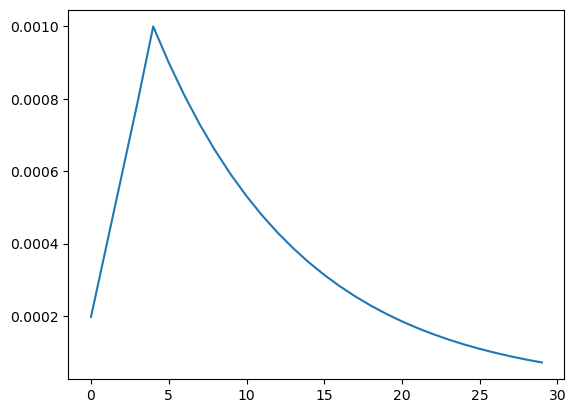

In [179]:
plt.plot(lrs)

In [ ]:
scheduler1 = ConstantLR(optimizer, factor=0.1, total_iters=2)
scheduler2 = ExponentialLR(optimizer, gamma=0.9)
scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[2])

for epoch in range(100):
    scheduler.step()

In [184]:
base_lr = 1e-3
warmup_lr = 1e-5
warmup_epochs = 5

optimizer = Adam(s_model.parameters(), lr=warmup_lr)
scheduler1 = StepLR(optimizer, step_size=1, gamma=1.5)
scheduler2 = ExponentialLR(optimizer, gamma=0.9)
scheduler = SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_epochs])

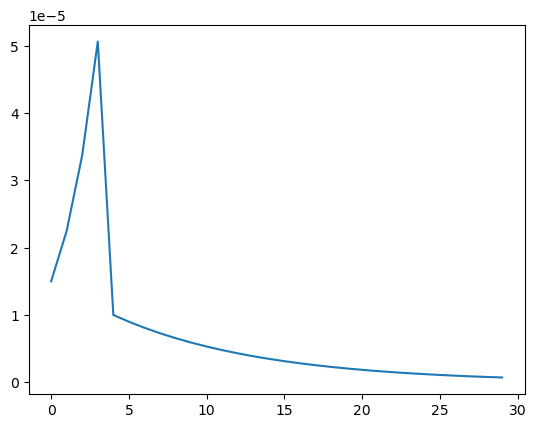

In [185]:
lrs = []

for i in range(30):
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])

plt.plot(lrs)